In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

In [2]:
import numpy as np
from sklearn import metrics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.CheXpertData import *
from modules.lib.Metrics import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [4]:
loaders = Loaders()
batch_size=16
val_percent=0.15
number_images = 20000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns

train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 1,060
Number of Validation Batches: 191
Number of Training Images: 16,960
Number of Validation Images: 3,056


In [5]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)       
        self.flattened_length_ = 1*320*320
        self.fc1 = nn.Linear(self.flattened_length_, 12)
       
    def forward(self, x):    
        x = x.view(-1, self.flattened_length_)    
        x = self.fc1(x)
        return x

In [6]:
net = SimpleModel()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320)) #Known Harded code size generated by data loaders (todo: make attribute of loaders)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]       1,228,812
       SimpleModel-2                   [-1, 12]               0
Total params: 1,228,812
Trainable params: 1,228,812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 0.00
Params size (MB): 4.69
Estimated Total Size (MB): 5.08
----------------------------------------------------------------


In [7]:
learning_rate = 1e-4
num_epochs = 2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

metrics = Metrics(target_columns, train_actual, val_actual, cc=0)

In [8]:
def parseLoaderData(data):
    """
    The data loaders output a dictionary with 3 keys
    The first 2 keys hold single values for the ImageID and the actual tensor of the image
    The last key holds the ground truth vector of the 12 lables
    """ 
    
    ids, inputs, labels = data['id'], data['img'], data['labels']
    # move data to device GPU OR CPU
    inputs, labels = inputs.to(device), labels.to(device)
    return ids, inputs, labels

In [9]:
def processBatch(net, data, optimizer=None):
    """
    Used for both training and validation.
    Validation will not pass in the optimizer.
    """

    # Convert output from loader
    ids, inputs, labels = parseLoaderData(data)
    
    if optimizer:
        # zero the parameter gradients
        optimizer.zero_grad()
        
    # Convert output to predicitons
    outputs = net(inputs)
    
    return ids, inputs, labels, outputs

In [10]:
def backProp(criterion, outputs, labels, optimizer):
    """
    Get loss value from criterion
    run backprop on the loss
    update weights in optimizer
    update epoch loss
    """
    
    loss = criterion(outputs, labels)#.float())
    loss.backward()
    optimizer.step()
    return loss.item()

In [11]:
epoch_loss = 0
losses_hx = {}

In [12]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    
    
    # Training
    net.train()
    for i, data in enumerate(train_loader, 0):
        ids, inputs, labels, outputs = processBatch(net, data, optimizer)
        metrics.appendEpochBatchData(ids, outputs)
        epoch_loss += backProp(criterion, outputs, labels, optimizer)

    metrics.closeEpoch(i)
    training_time_elapsed = datetime.now()
    start_time = datetime.now()
    
    # Validation
    net.eval()
    with torch.no_grad():
      for data in val_loader:          
            ids, inputs, labels, outputs = processBatch(net, data)
            metrics.appendEpochBatchData(ids, outputs, is_validation=True)
   
    metrics.closeEpoch(i, is_validation=True)
    validation_time_elapsed = datetime.now()
    
    
    # stdout Results
    print('=' * 50 + f'\nEpoch [{epoch+1}/{num_epochs}]\n' + '=' * 50)
    print(f'Epoch Loss: {epoch_loss:.4f} \
\nTraining Time: {training_time_elapsed})  \
\nValidation Time: {validation_time_elapsed})')
    
    metrics.displayMetrics(showMetricDataFrame=False,
                           showROCCurves=False, 
                           showPrecisionRecallCurves=False, 
                           include_targets=['Edema', 'Lung_Opacity', 'Pneumonia'])

Epoch [1/2]
Epoch Loss: 772.3386 
Training Time: 2020-07-30 16:44:06.262981)  
Validation Time: 2020-07-30 16:44:20.109951)

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.095764
Hamming Loss,0.179259
Combined Recall,0.242378
Combined Precision,0.259630
Combined F1,0.226475



VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.115662
Hamming Loss,0.159404
Combined Recall,0.301035
Combined Precision,0.343288
Combined F1,0.289155


Epoch [2/2]
Epoch Loss: 1503.1879 
Training Time: 2020-07-30 16:45:40.008188)  
Validation Time: 2020-07-30 16:45:52.535652)

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.100956
Hamming Loss,0.173860
Combined Recall,0.257597
Combined Precision,0.276400
Combined F1,0.241352



VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.052097
Hamming Loss,0.205494
Combined Recall,0.271841
Combined Precision,0.240323
Combined F1,0.232925



TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.100956
Hamming Loss,0.173860
Combined Recall,0.257597
Combined Precision,0.276400
Combined F1,0.241352


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,877,0.058153,0.068919,0.063080,0.546395,0.062447
1,Cardiomegaly,1911,0.178441,0.209331,0.192655,0.609138,0.162620
2,Lung_Opacity,7777,0.508937,0.511237,0.510084,0.569974,0.512278
3,Lung_Lesion,728,0.065934,0.078176,0.071535,0.552946,0.054743
4,Edema,4034,0.323252,0.350349,0.336256,0.616377,0.324805
5,Consolidation,993,0.069486,0.082833,0.075575,0.542995,0.069846
6,Pneumonia,459,0.037037,0.040964,0.038902,0.533757,0.030302
7,Atelectasis,2719,0.165870,0.192488,0.178190,0.542528,0.178669
8,Pneumothorax,1377,0.117647,0.139415,0.127609,0.578223,0.109750
9,Pleural_Effusion,5790,0.431088,0.449649,0.440173,0.620718,0.436286


***** ROC *****


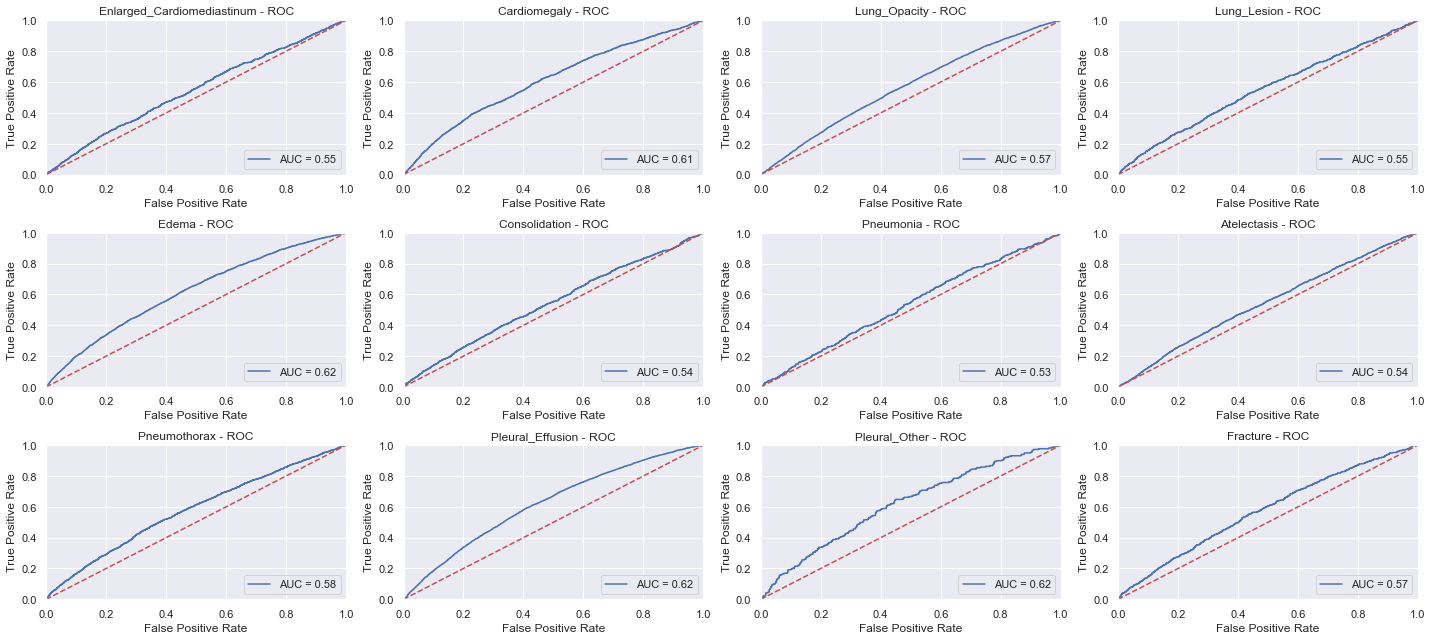

***** Precision / Recall *****


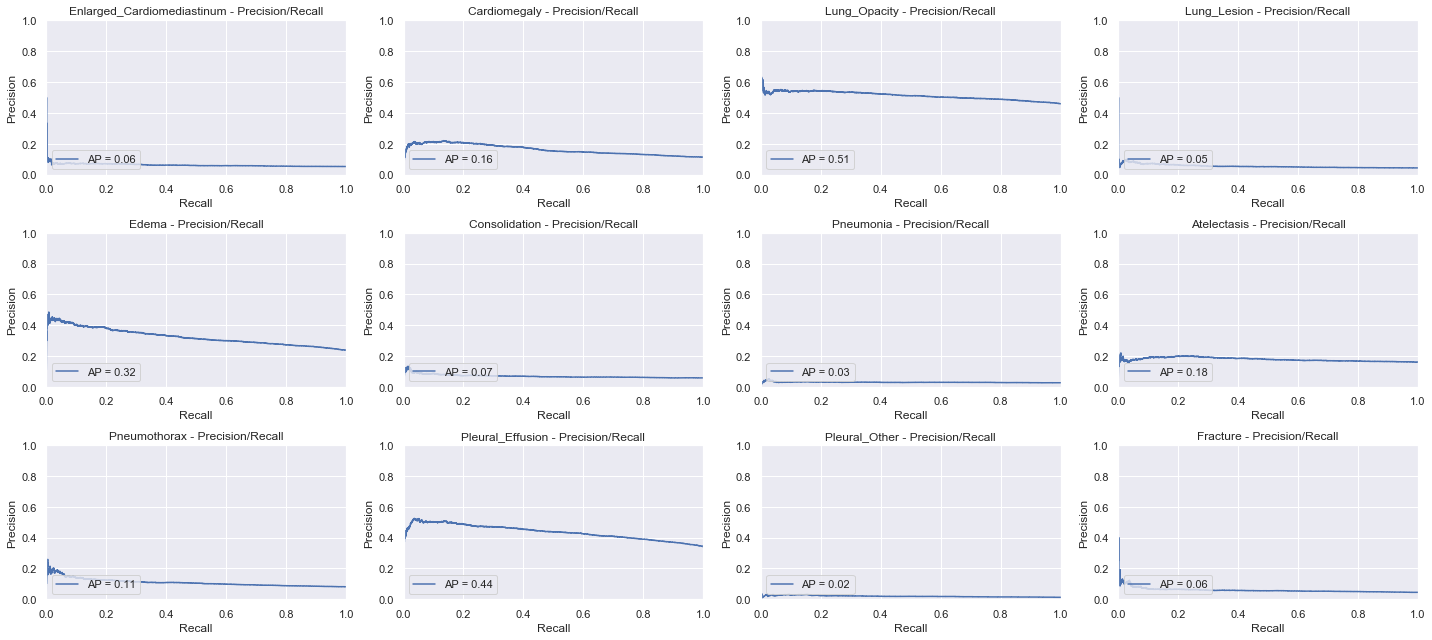


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.052097
Hamming Loss,0.205494
Combined Recall,0.271841
Combined Precision,0.240323
Combined F1,0.232925


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,155,0.012903,0.117647,0.023256,0.520663,0.062875
1,Cardiomegaly,324,0.037037,0.222222,0.063492,0.622388,0.158553
2,Lung_Opacity,1379,0.582306,0.534977,0.557639,0.612367,0.540270
3,Lung_Lesion,117,0.042735,0.043103,0.042918,0.581339,0.048520
4,Edema,721,0.682386,0.303142,0.419795,0.637166,0.328551
5,Consolidation,182,0.021978,0.057971,0.031873,0.495554,0.060935
6,Pneumonia,89,0.000000,0.000000,0.000000,0.487932,0.027927
7,Atelectasis,474,0.002110,0.076923,0.004107,0.509684,0.155103
8,Pneumothorax,227,0.176211,0.094563,0.123077,0.534049,0.091407
9,Pleural_Effusion,1035,0.213527,0.465263,0.292715,0.636308,0.433488


***** ROC *****


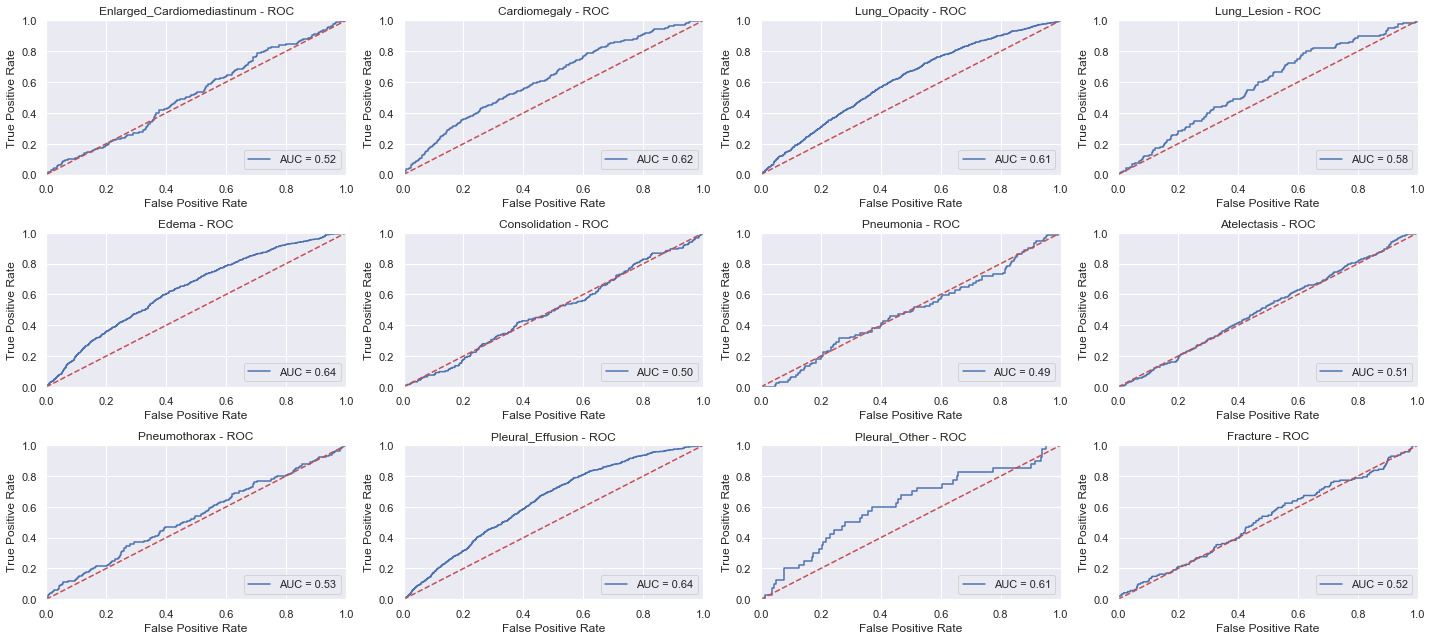

***** Precision / Recall *****


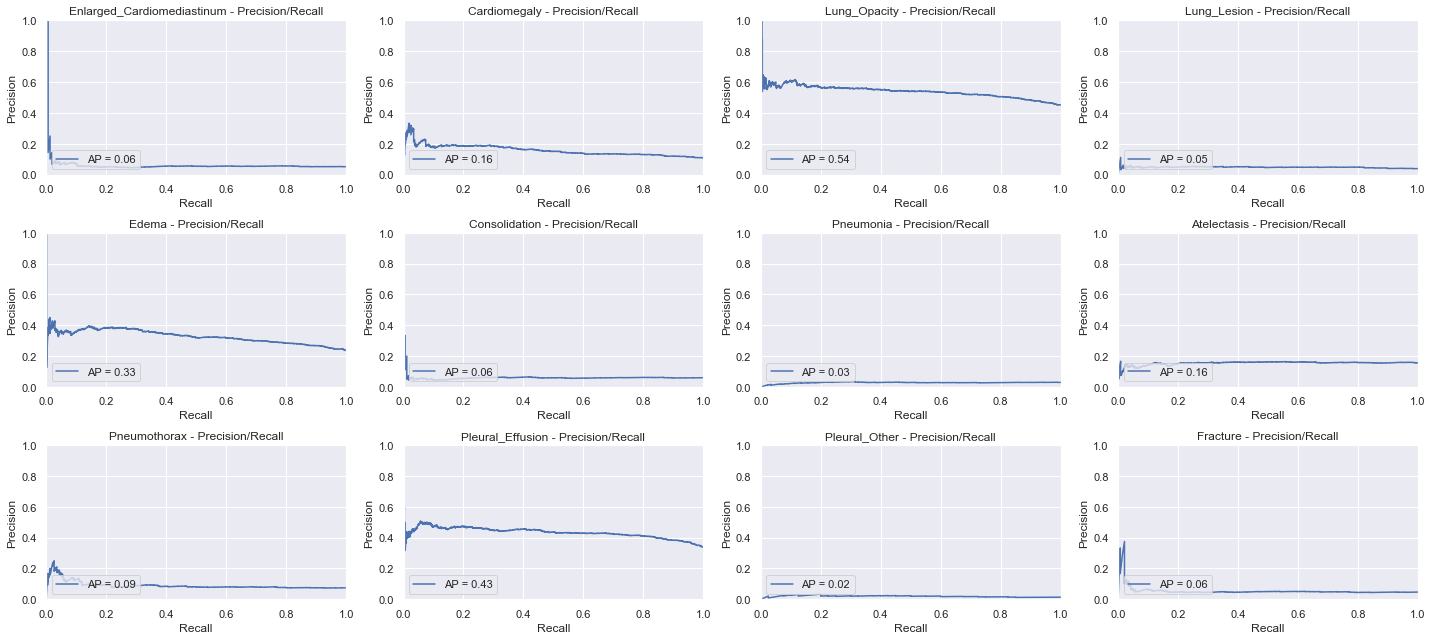

In [13]:
metrics.displayMetrics()

## Results

Since the model was not expected to do better than a 50/50 chance, the final metric output looks good.

One of the best indicators of the 50/50 model is the ROC curves.  For training, all the curves are on the diagonal.

Also, the P/R curves do not look like P/R curves.  In fact, the Average Precision approximates the ground truth positive percentages.
